# Predicting the Restaurant Closure

In the previous section, we used the Yelp dataset to create several features for our restaurant closure prediction model. We will now train the model and predict the restaurant closure.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [2]:
final_data = pd.read_pickle('data/yelp_final_data.pkl') # Reads the data saved from the features file
final_data.head(5)

,business_id,stars_business,review_count,is_open,is_chain,relative_review,polarity_score,yelp_age,recent_reviews,check_in_counts
0,---kPU91CF4Lq2-WlRu9Lw,4.5,0.002512,1,0,-0.252754,0.851179,0.116569,0.006757,0.000274
1,--0iUa4sNDFiZFrAdIWhZQ,3.0,0.001190,1,0,-0.462739,0.544421,0.721304,0.000000,0.000249
2,--8IbOsAAxjKRoYsBFL-PA,3.0,0.002909,0,1,-0.300230,0.261070,0.218872,0.000000,0.000798
3,--ARBQr1WMsTWiwOKOj-FQ,4.5,0.002380,0,0,-0.355721,0.920148,0.186933,0.004505,0.000848
4,--MbOh2O1pATkXa7xbU6LA,4.0,0.002644,0,0,-0.472317,0.844852,0.270914,0.005631,0.002568


Just to recap, we have the following features:
- **stars_business**: restaurant's average rating received by the customers. The stars vary from 1 to 5.
- **review_count**: scaled number of reviews written for the restaurant.
- **is_chain**: classifies if the restaurant is part of chain/franchise business, like McDonalds.
- **relative_review**: number of reviews written for the restaurant, relative to the restaurants located nearby.
- **polarity_score**: average sentiment score of how good/bad was the customer's review.
- **yelp_age**: scaled age of how long the business has been open based on the first and the last Yelp review
- **check_in_counts**: scaled number of check-ins for a restaurant.

Since we are trying to predict if the restaurant is going to be open or not (1 or 0 respectively), we will use a logistic regression.

In [3]:
final_data.shape # Double checks if any of the data is lost

(63757, 10)

In [4]:
print(f"{final_data['is_open'].value_counts()[1]:,} restaurants are open and {final_data['is_open'].value_counts()[0]:,} are closed")

43,914 restaurants are open and 19,843 are closed


***
## Logistic Regression Model

Suppose we create an indiscriminate model that predicts the business will stay open all the time. Then, this model would predict with $\frac{43914}{43914+19843} = \frac{43914}{63757} \approx$ 68.88%  accuracy and  precision. Hence, our model should do better than this baseline to be useful. 

We will now split the data into a train set and a test set.

In [5]:
features = final_data.drop(columns=["business_id", "is_open"])
close = final_data["is_open"]

X_train, X_test, y_train, y_test = train_test_split(features, close, test_size=0.2, stratify=close)

We will use the **stratify** parameter here since the data is skewed toward the open restaurants. This should ensure that the target variable (*is_open*) is proportionally represented in both the training and testing datasets. Let's train our model and analyze the result.

In [6]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"Test Accuracy: {accuracy_score(y_test, y_pred): %}")
print(f"Test Precision: {precision_score(y_test, y_pred): %}")

Test Accuracy:  74.937265%
Test Precision:  77.628326%


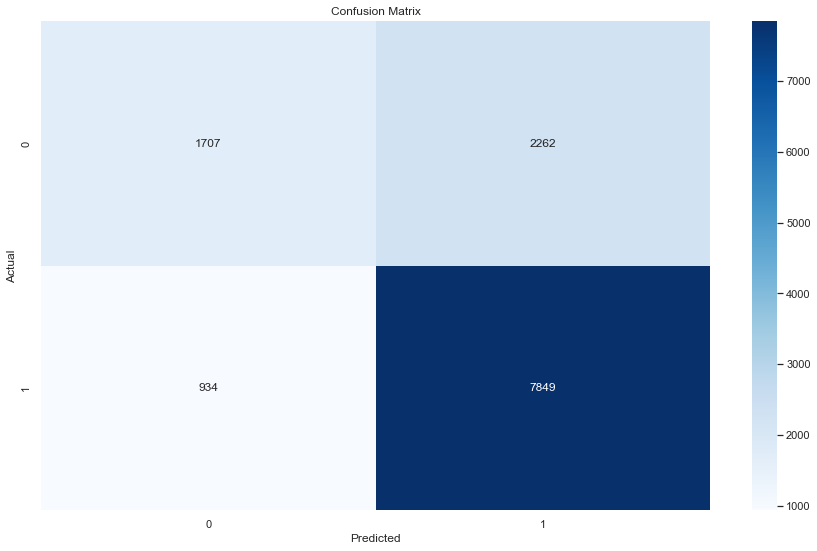

In [7]:
# Configures the plot style
sns.set(style="darkgrid", context="talk", palette="Dark2")
sns.set(rc={"figure.figsize": (15,9)})

sns.heatmap(confusion_matrix(y_test, y_pred), fmt="g", annot=True, cmap="Blues")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Our model has better accuracy and precision than an indiscriminate model that predicts *open* all the time, but the confusion matrix tells us that the model is having trouble predicting the *closed* restaurants.

Moreover, since the prediction model is suppose to be helpful to the investors (like banks), we would like to increase precision over accruacy, and hence, we will increase the threshold value, which is a decision boundary that separates the positive and negative classes.

In [8]:
probs = model.predict_proba(X_test)
threshold = 0.7 # Can be increased/decreased depending on the goal
y_pred = (probs[:, 1] >= threshold).astype(int)

print(f"Test Accuracy: {accuracy_score(y_test, y_pred): %}")
print(f"Test Precision: {precision_score(y_test, y_pred): %}")

Test Accuracy:  68.891154%
Test Precision:  84.597701%


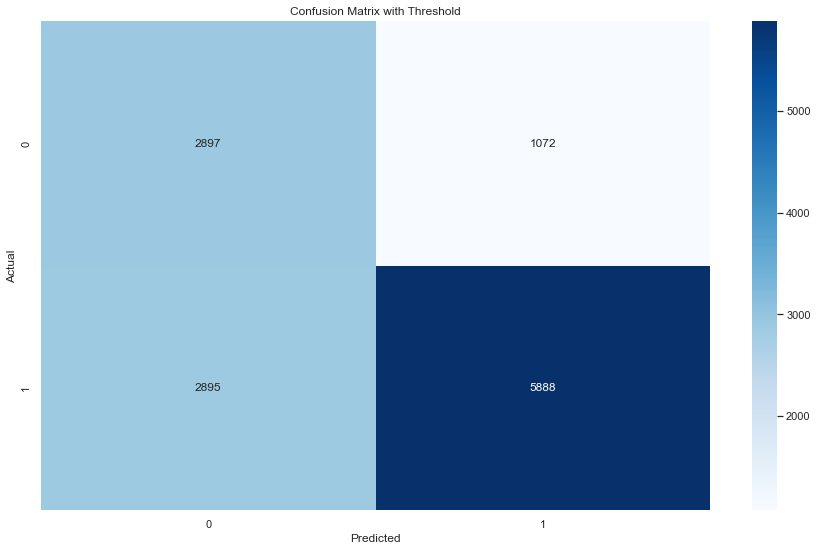

In [9]:
sns.heatmap(confusion_matrix(y_test, y_pred), fmt="g", annot=True, cmap="Blues")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix with Threshold")
plt.show()

As expected, the accruacy decreased but the precision increased, as the number of false negative decreased according to the confusion matrix. Let's check the mean accuracy and precision to make sure that our results are not due to chance.

In [10]:
accuracies = [] 
precisions = []

for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(features, close, test_size=0.2, stratify=close)
    
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    probs = model.predict_proba(X_test)
    
    threshold = 0.7
    y_pred = (probs[:, 1] >= threshold).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    
    accuracies.append(accuracy)
    precisions.append(precision)

print(f"Mean Test Accuracy: {np.mean(accuracies): %}")
print(f"Mean Test Precision: {np.mean(precisions): %}")

Mean Test Accuracy:  69.313770%
Mean Test Precision:  84.768506%


The model achieves a relatively higher **precision** rate compare to the indiscriminate model, but however, it basically has the same accuracy rate. I think our model is a decent classifier, given that my friend Andrew's model achieves an average precision of 80% and accuracy of 64% with 5 features and other referenced model achieves an average precision of 91% and accuracy of 65% with a lot more features.

***
## Model Analysis

We will take a closer look at the model by analyzing the ROC curve and the AUC score. This will help us to understand if the model is able to classify the target variable (*is_open*) relatively well. Keep in mind that the model is "better" if the ROC curve is converging to 1 faster (closer to the top left corner) and if the AUC score is closer to 1.

Text(0.5, 1.0, 'ROC Curve')

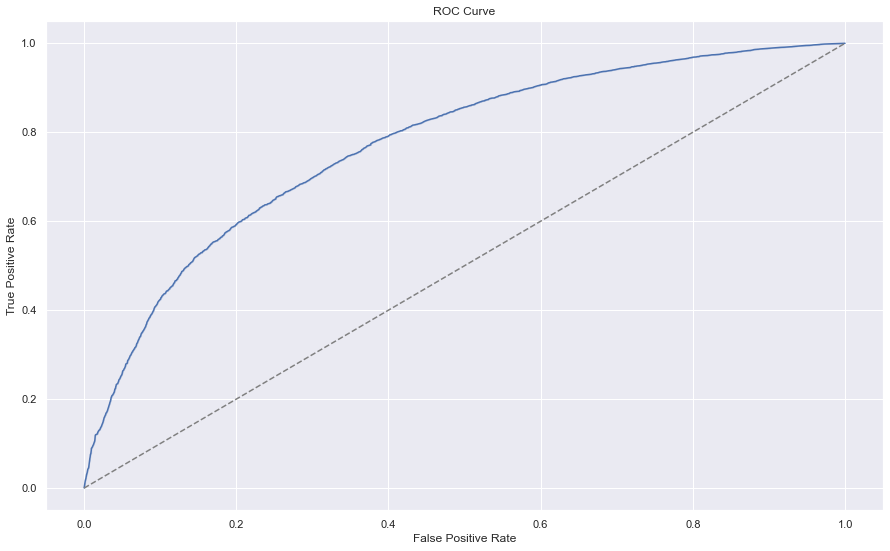

In [11]:
prob = model.predict_proba(X_test) # Use predict_proba method for the threshold
prob = prob[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, prob)

sns.lineplot(x=fpr, y=tpr) # ROC Curve
plt.plot([0, 1], [0, 1], linestyle="--", color="gray") # Adds linear line for the indiscriminate model

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

In [12]:
auc_score = auc(fpr, tpr)
print(f"AUC Score: {round(auc_score, 5)}")

AUC Score: 0.7721


The ROC curve and the AUC score suggest that our model is not that great, but it is not so terrible either, given that we did not have as many features. Now, we will take a look at the coefficients of the features that were used in the model to predict the outcome.

In [13]:
feature_coefficient = model.fit(X_train, y_train).coef_[0]

for feature, coefficient in zip(X_train.columns, feature_coefficient):
    print(f'{feature}: {round(coefficient, 5)}')

stars_business: 1.39788
review_count: -1.68926
is_chain: 0.97412
relative_review: 0.38861
polarity_score: -3.71398
yelp_age: 3.07011
recent_reviews: 1.14738
check_in_counts: -5.11534


### Stars
As we anticipated, the the stars rating given to a restaurant is postively related to staying open. Higher stars (such as 5) gives higher confidence to the consumers by minimizing risk of bad dining experience, and shows that the restaurant is already proven worthy by the other customers.

### Review Counts
Surprisingly, the number of reviews is negatively related. Maybe our initial hypothesis on how more reviews guarantee a worthwhile experience was incorrect, and having more reviews does not necessarily mean the restaurant will stay open. In addition, I heard that some restaurants on Yelp receives spam reviews and sometimes even pay for the fake reviews, which then suggest that this feature might not be strongly correlated to the target variable.

### Chain
Whether a restaurant is part of franchise chain or not is positively related. Like we discussed in the previous section, the chain restaurants already have established their brands, and as a result, the consumers are already familiar with the taste & service. Most importantly, the chain restaurants can receive financial help from the headquarters, making harder for them to close down.

### Relative Review
The sign of the relative review of restaurant in the cluster of restaurants is also positive, which implies that restaurants in a locally dense area are more likely to stay open. The competition among restaurants could be attracting more customers to the region by providing new and more food options to the people.

### Polarity Score
The sentiment score calculated from the review texts is negatively related. This is odd because if the restaurant is getting negative reviews (such as -0.5), then the restaurant will likely to close down since fewer customers will visit the restaurants after reading the bad reviews on Yelp. It is possible that this feature is associated with the *review counts* feature and likewise, it also might not be a strong predictor variable.

### Yelp Age
The restaurant's Yelp age is positively related. Restaurants that were in business for a long time will continue to be in business since they are already established with the name value, and they probably have a consistent, stable profit model to earn more revenue.

### Recent Reviews
Number of latest/recent reviews received within a time interval is positively related as well. This is not surprising because having more recent reviews implies that the customers are dining in the restaurant consistently, and as a result, the probability of restaurant closure will decrease.

### Check-in Counts
Lastly, check-in counts are negatively related to the target variable, which is unexpected since more check-in should be related to having more customers. However, similar to *review counts* and *polarity score* features, the check-in counts could be misleading because it might be primarily used for social media purpose and not necessarily because the food and/or service of the restaurant is worth the money and time.

***
## Model Limitations

### Data Skewness
When we initially explored the Yelp dataset, we found out that about 69% restaurants in the data were classified as open. As a result, our model classifies the open restaurants decently, but certainly has limitation with identifying the closed restaurants. We were able to trade-off the accuracy of the model with precision, which could be more important for the investors.

### Incomplete Dataset
The dataset was limited from the start because of the timing difference. The restaurants that were open in the Yelp dataset might not be open today. It also excludes the restaurants that closed down in the earlier period and the restaurants in rest of the states. Furthermore, we might have lost some of the data from our restaurant category filter. 

### Estimated Features
The estimated Yelp age feature could be very off from the actual age since some restaurants might not have used Yelp until recently. For example, if a restaurant decides to list its name in 2018 after operating for more than 20 years, then clearly, the difference in age could cause an issue, especially if the restaurant closes down shortly after (say like 2019).

VADER tool used to calculate the polarity score could be inaccurate since it will not capture sarcasm or negative words used for positive connotation. Maybe, we could consider different analytical tools such as Flair. 

By chance, restaurants that were identified as a chain might not actually be a chain. We decided that a restaurant is part of a chain if the same name appears in the data at least four times. Since the data is big, there is a chance that the same name appears more than four times and not be a chain. In addition, some of the smaller, successful restaurants often expand their businesses by opening a restaurant in a nearby location under the same name. In this case, we cannot easily decide if this restaurant should be classified as a chain or non-chain.

### Predicting New Restaurants
Our model might not work well with newly opened restaurants because of insufficent and skewed features. The new restaurants (or newly listed on Yelp in general) will have fewer review comments, low Yelp age, and possibly skewed stars rating. Hence, if the investors were to use this model to predict the closure of newly open restaurant, then we would expect a lower accuracy & precision.

***
## Future Improvements

Building on my friend Andrew's and another person's projects, we can consider the following improvements.
- Using photo data in the Yelp dataset to see if good food photos are correlated to the restaurant closure. Good photos taken by the customer could be a strong predictor than the reviews since it is less subjective, but however, it will be difficult to classify what is considered as a good/bad photo.
- Compare the result with different models, such as random forest, and see which one performs the best, along with the optimized parameters for each models.
- Including additional features in Yelp, like health inspection rate and the price range. Low health inspection score and could lead to a business shutdown.
- See the demographics around the clusters that we created through GMM. Maybe a specific cuisine is more popular in the area, or determine if one area is more populated than the other.
- Simply more data